# bike-a-bility in Barrio Logan & Hillcrest 

An intial case study for demoing the `bike2books` project.

In [1]:
%matplotlib inline  
import matplotlib.pyplot as plt

import gmaps
gmaps.configure(api_key="ADD ME")
                
import numpy as np
import pandas as pd
import geopandas as gpd 

from pprint import pprint
from bike2books import travel
from bike2books import sample

flip = travel.flip_coords

# Premise

The City of San Diego is investing in substantial improvements in biking [infrastructure](https://www.sandiego.gov/sites/default/files/legacy/planning/programs/transportation/mobility/pdf/bicycle_master_plan_final_dec_2013.pdf). A long-term effort like this can be difficult to explain to the community in way they find intuitive and meaningful....

The `bike2books` project provides a simple and meaningful metric of a neighborhood's bike-a-bility: _on average how long does it take to bike safely to your nearest library?_ 

- Libraries are often centrally located in their neighborhoods, they are familiar landmarks, and are used by a wide range of the community. If someone feels comfortable biking to their library, they should feel comfortable biking elsewhere in their neighborhood. At least that's the idea. 

- `bike2books` may also be a useful metric in thinking about where to add bicycle infrastructure. The Bike Master Plan focus on both lager between neighborhood connections (which are important), and local 'choke points'. This tool provides one way to estimate those changes impact on a measure of overall bike-a-bility. 

- The idea I'm exploring is really that if people are to bike more, they should be comfortable biking near their homes. If this intuition in countered by exiting data, and citizen input, it would need revision or replacement. 

- This is not a complete measure of course. It may not be good metric for commuting, for example. That said, a metric like this might be helpful in San Diego developing a bike friendly brand.


---

This Python module includes *the beginning* of a tool set for re-sampling based statistical simulations to analyze the bike "bike-a-bility" of each neighborhood in San Diego. The key idea is to develop a good estimate of average travel time to a library, using a data-driven re-sampling approach (i.e. bootstrapping). 

### In summary:

1. A "trip" starts at random point in a neighborhood. 
2. The model then estimates the travel time from that point to the closest library, by bike and car. 
3. Bike trips are penalized for safety (see next section).
4. Car trips have a parking penalty (see next section).


- The average bike travel time for `N` simulated trips is the bike-a-bility score. Smaller is better.
- When the bike-a-bility score falls below the car travel time, biking can be considered a better choice for efficient safe mobility.

### Key details

- Bike travel time is penalized when the route does not *easily* include a bike lane or path. This penalty may not reflect the actual travel time, but for biking to become popular it needs to be seen as safe. Providing several measures of bike-a-bility (e.g. one for time, one for safety) can make understanding and quantifying progress difficult. By converting safety (as measure by bike lane availability) into units of time, we can introduce a single bike-a-bility metric. One that lends itself to comparison with other ways of getting around, and is easily understood. 

- Bike results are compared to average travel-time by car, penalized by an estimate of how long it might take to park. Parking penalties are based on nearby parking meter usage.

- In the future travel times will be estimated using the Google Maps API. At present that are __very crude__ estimates based on line-of-sight distance.

# The experiment

To see how `bike2books` works I'll compare the bike-a-bility of two San Diego neighborhoods - Hillcrest and Barrio Logan. 

First, we locate the two neighborhoods.

In [2]:
bario_logan = travel.neighborhood_location("Barrio Logan")     
hillcrest = travel.neighborhood_location("Hillcrest")     

How far are they apart?

In [3]:
d = travel.distance_in_miles(hillcrest, bario_logan)
print("{} miles.".format(d))

2.38117846781 miles.


Plot them in Google Maps

In [4]:
fig = gmaps.figure()
layer = gmaps.marker_layer([flip(hillcrest), flip(bario_logan)])
fig.add_layer(layer)
fig

Figure()

Great. That's sensible. Let's get to work.

# 100 trips

- First we simulate 100 random trips, one from each neighborhood. 

- Each trip starts within a 0.5 mile radius of the neighborhood's center.

In [5]:
N = 100
r = .5

hillcrest_samples = sample.trips(N, hillcrest, radius=r)
bl_samples = sample.trips(N, bario_logan, radius=r)

Plot trip starting points in Hillcrest.

In [6]:
hillcrest_points = [flip((row[1], row[2])) for row in hillcrest_samples]
fig = gmaps.figure()
layer = gmaps.marker_layer(hillcrest_points)
fig.add_layer(layer)
fig

Figure()

And in B.L.

In [7]:
bl_points = [flip((row[1], row[2])) for row in bl_samples]
fig = gmaps.figure()
layer = gmaps.marker_layer(bl_points)
fig.add_layer(layer)
fig

Figure()

For each trip estimate the travel time from each starting point to the closests library.

In [8]:
hillcrest_points = [(row[1], row[2]) for row in hillcrest_samples]

distance_hillcrest = []
closest_hillcrest = []
names_hillcrest = []

for p in hillcrest_points:
    name, d, c = travel.nearest_library(p)
    
    distance_hillcrest.append(d)
    closest_hillcrest.append(c)
    names_hillcrest.append(name)
    
print("Closest libraries:")
pprint(list(np.unique(names_hillcrest)))

Closest libraries:
[u'Mission Hills']


In [9]:
bl_points = [(row[1], row[2]) for row in bl_samples]

distance_bl = []
closest_bl = []
names_bl = []
for p in bl_points:
    name, d, p_i = travel.nearest_library(p)
    
    closest_bl.append(p_i)
    distance_bl.append(d)
    names_bl.append(name)

print("Closest libraries:")
pprint(list(np.unique(names_bl)))

Closest libraries:
[u'Logan Heights', u'San Diego Cental']


Now estimate travel times for each neighborhood

In [10]:
bike_hillcrest = []
drive_hillcrest = []

for x, y in zip(hillcrest_points, closest_hillcrest):
    bike_hillcrest.append(travel.bike_time(x, y))
    drive_hillcrest.append(travel.drive_time(x, y))

In [11]:
bike_bl = []
drive_bl = []

for x, y in zip(bl_points, closest_bl):
    bike_bl.append(travel.bike_time(x, y, p=.3))
    drive_bl.append(travel.drive_time(x, y))

# Results
Plot average bike-a-bility in both neightborhoods, measured by cycling safety-adjusted travel time. Compare to average travel times by car, penalized by an estimate of parking time.

In [12]:
bike_means = np.asarray([np.mean(bike_hillcrest), np.mean(bike_bl)])
bike_stds = np.asarray([np.std(bike_hillcrest), np.std(bike_bl)])

drive_means = np.asarray([np.mean(drive_hillcrest), np.mean(drive_bl)])
drive_stds = np.asarray([np.std(drive_hillcrest), np.std(drive_bl)])

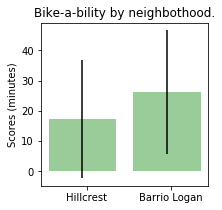

In [13]:
fig, ax = plt.subplots(figsize=(3, 3))

ind = np.arange(2)
width = 0.8

rects1 = ax.bar(ind, bike_means*60, width, color='green', alpha=0.4, yerr=bike_stds*60)
# rects2 = ax.bar(ind + width, drive_means, width, color='grey', alpha=0.3, yerr=drive_stds)

ax.set_title('Bike-a-bility by neighbothood.')
ax.set_ylabel('Scores (minutes)')
ax.set_xticklabels(('Hillcrest', 'Barrio Logan'))
ax.set_xticks(ind + width / 16);

Compare to car travel

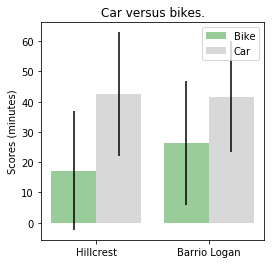

In [14]:
fig, ax = plt.subplots(figsize=(4, 4))

ind = np.arange(2)
width = 0.4

rects1 = ax.bar(ind, bike_means*60, width, color='green', alpha=0.4, yerr=bike_stds*60)
rects2 = ax.bar(ind + width, drive_means*60, width, color='grey', alpha=0.3, yerr=drive_stds*60)

ax.set_title('Car versus bikes.')
ax.set_ylabel('Scores (minutes)')
ax.set_xticklabels(('Hillcrest', 'Barrio Logan'))
ax.set_xticks(ind + width / 2)

ax.legend((rects1[0], rects2[0]), ('Bike', 'Car'));

# Conclusions



- This data-driven [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) simulations suggest Hillcrest has about twice the bike-a-bility of Barrio Logan.
- Traveling by bike is about twice as fast as driving, which is (somewhat) surprising for these short distances.

# Caveats

- Substantial work is needed on validation, espcially on points 3 and 4 in the `Premise` section above.
- These simulations use __many__ approximations and shortcuts, none of which are validated. This appraoch may prove valuable, but for now....
- **DO NOT TRUST THESE RESULTS. FOR DEMO USE ONLY**